In [1]:
# Enabling the `widget` backend.
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be installed via pip or conda.
# for more details, see: https://github.com/matplotlib/ipympl
%matplotlib widget

import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import pandas as pd
import numpy as np

import time
import datetime

In [42]:
# flags to activate/deactivate temperature measurement sources
ENABLED_KEYSIGHT_DMM = False
ENABLED_DS18B20_GPIO = True
ENABLED_BME280_I2C = True
ENABLED_OPUS20 = True

# initialize the array storing the labels of temperature measurement sources
temp_measurement_sources_arr = []
sensor_number = 0

In [43]:
if ENABLED_KEYSIGHT_DMM:
    #KEYSIGHT_IP = '192.168.12.150'
    KEYSIGHT_IP = '192.168.10.113'
    #KEYSIGHT_TEMP_CONF = '01_PT100_4WIRE'
    #KEYSIGHT_TEMP_LABEL = 'Sensor 1: Pt100-4wire @Keysight'
    KEYSIGHT_TEMP_CONF = '02_PT1000_2WIRE'
    sensor_number += 1
    KEYSIGHT_TEMP_LABEL = 'Sensor ' + str(sensor_number) + ': Pt1000-2wire @Keysight'
    
    temp_measurement_sources_arr.append(KEYSIGHT_TEMP_LABEL)

In [44]:
if ENABLED_BME280_I2C:
    # i2c bus device /dev/i2c-11 or /dev/i2c-22
    BME280_I2C_BUS_DEV = 11
    # i2c address of BME280 on i2c bus
    BME280_I2C_ADDR = 0x76
    sensor_number += 1
    BME280_TEMP_LABEL = 'Sensor ' + str(sensor_number) + ': BME280 @I2C'
    
    temp_measurement_sources_arr.append(BME280_TEMP_LABEL)

In [45]:
if ENABLED_DS18B20_GPIO:
    from w1thermsensor import W1ThermSensor, Sensor
    
    # connect to DS18B20 sensors
    sensor_obj = W1ThermSensor()
    sensor_list = sensor_obj.get_available_sensors([Sensor.DS18B20])
    
    for sensor in sensor_list:
        sensor_number += 1
        DS18B20_GPIO_TEMP_LABEL = 'Sensor ' + str(sensor_number) + ': DS18B20 @GPIO'
        temp_measurement_sources_arr.append(DS18B20_GPIO_TEMP_LABEL)

In [46]:
if ENABLED_OPUS20:
    OPUS20_IP = '192.168.10.157'
    sensor_number += 1
    OPUS20_TEMP_LABEL = 'Sensor ' + str(sensor_number) + ': OPUS20 @LAN'
    
    temp_measurement_sources_arr.append(OPUS20_TEMP_LABEL)

In [47]:
temp_measurement_sources_arr

['Sensor 1: BME280 @I2C',
 'Sensor 2: DS18B20 @GPIO',
 'Sensor 3: DS18B20 @GPIO',
 'Sensor 4: DS18B20 @GPIO',
 'Sensor 5: OPUS20 @LAN']

In [48]:
if ENABLED_KEYSIGHT_DMM:
    # import wrapper class PyVisa_Keysight_34465A from python file PyVisa_Keysight_34465A_class.py
    # from ../PyVisa_Keysight_34465A_class.py import PyVisa_Keysight_34465A

    # class PyVisa_Keysight_34465A has to imported via importlib due to different path of notebook and class file
    import importlib.util

    spec = importlib.util.spec_from_file_location("PyVisa_Keysight_34465A", "./PyVisa_Keysight_34465A_class.py")
    keysight_class = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(keysight_class)

In [50]:
if ENABLED_BME280_I2C:
    import smbus2
    import bme280

In [51]:
if ENABLED_OPUS20:
    from opus20 import Opus20, OPUS20_CHANNEL_SPEC

In [52]:
def dataframe_add_row(df=None, row=[]):
    if (df is None):
        return
    
    # add a row
    df.loc[-1] = row
    
    # shift the index
    df.index = df.index + 1
    
    # reset the index of dataframe and avoid the old index being added as a column
    df.reset_index(drop=True, inplace=True)

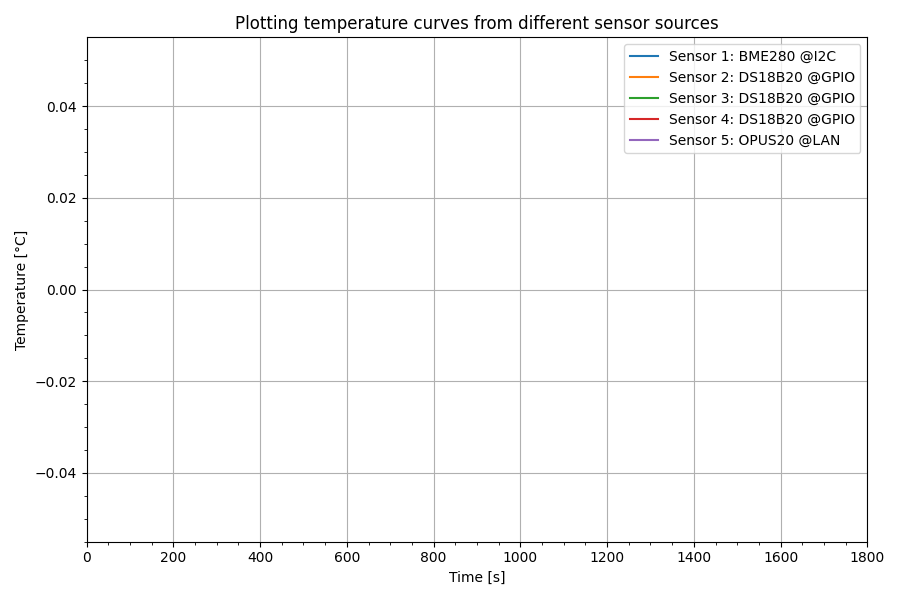

In [63]:
INTERVAL = 0.5

if ENABLED_DS18B20_GPIO:
    # initialization of the temperature array in size according to the number of sensors
    temp_array = np.empty(len(sensor_list), dtype=object)

if ENABLED_KEYSIGHT_DMM:
    # create new device object for the digital multimeter (DMM) Keysight 34465A
    dmm = keysight_class.PyVisa_Keysight_34465A(tcp_ip = KEYSIGHT_IP)

    # configure Keysight DMM for temperature measurement with a valid configuration
    dmm.confTempMeasure(KEYSIGHT_TEMP_CONF)

if ENABLED_BME280_I2C:
    i2c_bus_dev = smbus2.SMBus(BME280_I2C_BUS_DEV)
    bme280_calibration_params = bme280.load_calibration_params(i2c_bus_dev, BME280_I2C_ADDR)

if ENABLED_OPUS20:
    o20 = Opus20(OPUS20_IP)

# get starting time
time_start_sec = float("{:.2f}".format(time.time()))

# initialize the dataframe that will store the measured values using the column labels of 
# activated temperature measurement sources
df_meas_values = pd.DataFrame(columns=['Time [s]'])

for idx, label in enumerate(temp_measurement_sources_arr):
    df_meas_values.insert(idx+1, label+' [°C]', '')

plt.ioff()

fig, ax = plt.subplots(figsize=(9,6))
fig.canvas.header_visible = False
fig.canvas.layout.min_height = '400px'

plt.title('Plotting temperature curves from different sensor sources')

# define the limits of the x-axis in seconds, from when the canvas should be scrolled
xlim_left = 0
#xlim_span = 600  # 10 minutes
xlim_span = 1800 # 0.5 h
xlim_right = xlim_left + xlim_span
xlim_scroll = xlim_span - 10

ax.set_xlim(xlim_left, xlim_right)

# create list of line objects
line_objects_arr = []
for idx, val in enumerate(temp_measurement_sources_arr):
    line_objects_arr.append('line_temp_'+str(idx))

# dynamically create line objects by list
for idx, val in enumerate(line_objects_arr):
    line_objects_arr[idx], = ax.plot(df_meas_values['Time [s]'], 
                                     df_meas_values[temp_measurement_sources_arr[idx]+' [°C]'], 
                                     label=temp_measurement_sources_arr[idx])

ax.grid(True)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Temperature [°C]')
ax.minorticks_on()

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

plt.legend()
plt.tight_layout()

fig.canvas.draw()
fig.canvas.flush_events()

display(fig.canvas)

In [65]:
#display(fig.canvas)

while True:
    try:
        # Get time relative to starting time and round to 2 decimals
        timestamp_sec = float("{:.2f}".format(time.time() - time_start_sec))
        # convert timestamp in seconds to human readable time string
        timestamp_str = str(datetime.timedelta(seconds=timestamp_sec))

        values_row = [timestamp_sec]
        
        if ENABLED_KEYSIGHT_DMM:
            # retrieve temperature values from Keysight DMM
            temp_dmm = dmm.getMeasurement()
            print("<{}>\t Pt100 Temperature: {:.7f} °C".format(timestamp_str, temp_dmm))
            values_row.append(temp_dmm)
            
        if ENABLED_BME280_I2C:
            # the sample method will take a single reading and return
            # a compensated_reading object
            bme280_data = bme280.sample(i2c_bus_dev, BME280_I2C_ADDR, bme280_calibration_params)
            print("<{}>\t BME280 Temperature: {:.7f} °C".format(timestamp_str, bme280_data.temperature))
            values_row.append(bme280_data.temperature)
        
        if ENABLED_DS18B20_GPIO:
            i = 0
            for sensor in sensor_list:
                temp_array[i] = sensor.get_temperature()
                print("<{}>\t DS18B20 Sensor: {:d} of {:d}, Temperature: {:.3f} °C, ID: {}"
                      .format(timestamp_str, i+1, len(sensor_list), temp_array[i], sensor.id))
                values_row.append(temp_array[i])
                i += 1

        if ENABLED_OPUS20:
            # retrieve temperature values from OPUS20 (channel '100' holds current temperature)
            temp_o20 = o20.multi_channel_value([100])
            print("<{}>\t OPUS20 Temperature: {:.7f} °C".format(timestamp_str, temp_o20[0]))
            values_row.append(temp_o20[0])
                
        dataframe_add_row(df_meas_values, values_row)

        # when the right edge of the canvas is reached, the canvas should continue to scroll to the left
        xlim_right = datetime.timedelta(seconds=df_meas_values['Time [s]'][0]) \
                     + datetime.timedelta(seconds=xlim_scroll)
        if (timestamp_sec >= xlim_right.total_seconds()):
            # drop first row of dataframe
            df_meas_values.drop(index=df_meas_values.head(1).index, inplace=True)
            # reset index of dataframe
            df_meas_values.reset_index(inplace=True, drop=True)

            # take the new first time value for the left boundary of the x-axis
            xlim_left = df_meas_values['Time [s]'][0]
            xlim_right = xlim_left + xlim_span
            ax.set_xlim(xlim_left, xlim_right)

        # Manual scaling of the y-axis
        #
        # get MIN and MAX values of the whole dataframe
        min_val_series = df_meas_values.min()
        max_val_series = df_meas_values.max()
        # drop first elements of the series, because it's the time in seconds and not relevant
        min_val_series.drop(min_val_series.index[0], inplace=True)
        max_val_series.drop(max_val_series.index[0], inplace=True)
        # add some space beneath min value and above max value (in °C)
        ylim_min = min_val_series.min() - 1.5
        ylim_max = max_val_series.max() + 1.5
        # set new scale of y-axis
        ax.set_ylim(ylim_min, ylim_max)
        
        # iterate over the list holding the line objects and set new x- and y-values
        for idx, val in enumerate(line_objects_arr):
            line_objects_arr[idx].set_xdata(df_meas_values['Time [s]'])
            line_objects_arr[idx].set_ydata(df_meas_values[temp_measurement_sources_arr[idx]+' [°C]'])

        #ax.relim()
        #ax.autoscale_view()

        fig.canvas.draw()
        fig.canvas.flush_events()

        time.sleep(INTERVAL)
        
    except:
        if ENABLED_KEYSIGHT_DMM:
            dmm.closeConnection()
        
        # The OPUS20 takes it very badly if the connection is not disconnected cleanly ...
        if ENABLED_OPUS20:
            o20.disconnect()
        
        print("Keyboard Interrupt ^C detected.")
        print("Bye.")
        break

<0:11:18.860000>	 BME280 Temperature: 24.6442366 °C
<0:11:18.860000>	 DS18B20 Sensor: 1 of 3, Temperature: 48.750 °C, ID: 3c01d0757a93
<0:11:18.860000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.125 °C, ID: cade071e64ff
<0:11:18.860000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.062 °C, ID: dbd9071e64ff
<0:11:18.860000>	 OPUS20 Temperature: 25.1206436 °C
<0:11:22.680000>	 BME280 Temperature: 24.6134528 °C
<0:11:22.680000>	 DS18B20 Sensor: 1 of 3, Temperature: 48.875 °C, ID: 3c01d0757a93
<0:11:22.680000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.125 °C, ID: cade071e64ff
<0:11:22.680000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.062 °C, ID: dbd9071e64ff
<0:11:22.680000>	 OPUS20 Temperature: 25.1206436 °C
<0:11:26.480000>	 BME280 Temperature: 24.6339754 °C
<0:11:26.480000>	 DS18B20 Sensor: 1 of 3, Temperature: 49.000 °C, ID: 3c01d0757a93
<0:11:26.480000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.125 °C, ID: cade071e64ff
<0:11:26.480000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.062 °C, ID: dbd907

<0:12:46.090000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.125 °C, ID: cade071e64ff
<0:12:46.090000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.062 °C, ID: dbd9071e64ff
<0:12:46.090000>	 OPUS20 Temperature: 25.1206436 °C
<0:12:49.850000>	 BME280 Temperature: 24.6647592 °C
<0:12:49.850000>	 DS18B20 Sensor: 1 of 3, Temperature: 51.062 °C, ID: 3c01d0757a93
<0:12:49.850000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.125 °C, ID: cade071e64ff
<0:12:49.850000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.062 °C, ID: dbd9071e64ff
<0:12:49.850000>	 OPUS20 Temperature: 25.1206436 °C
<0:12:53.610000>	 BME280 Temperature: 24.6647592 °C
<0:12:53.610000>	 DS18B20 Sensor: 1 of 3, Temperature: 51.188 °C, ID: 3c01d0757a93
<0:12:53.610000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.125 °C, ID: cade071e64ff
<0:12:53.610000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.062 °C, ID: dbd9071e64ff
<0:12:53.610000>	 OPUS20 Temperature: 25.1206436 °C
<0:12:57.380000>	 BME280 Temperature: 24.6442366 °C
<0:12:57.380000>	 DS18B2

<0:14:14.090000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.062 °C, ID: dbd9071e64ff
<0:14:14.090000>	 OPUS20 Temperature: 25.1243267 °C
<0:14:17.910000>	 BME280 Temperature: 24.6442366 °C
<0:14:17.910000>	 DS18B20 Sensor: 1 of 3, Temperature: 52.250 °C, ID: 3c01d0757a93
<0:14:17.910000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.125 °C, ID: cade071e64ff
<0:14:17.910000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.062 °C, ID: dbd9071e64ff
<0:14:17.910000>	 OPUS20 Temperature: 25.1243267 °C
<0:14:21.700000>	 BME280 Temperature: 24.6339754 °C
<0:14:21.700000>	 DS18B20 Sensor: 1 of 3, Temperature: 52.312 °C, ID: 3c01d0757a93
<0:14:21.700000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.125 °C, ID: cade071e64ff
<0:14:21.700000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.062 °C, ID: dbd9071e64ff
<0:14:21.700000>	 OPUS20 Temperature: 25.1129532 °C
<0:14:25.600000>	 BME280 Temperature: 24.6288447 °C
<0:14:25.600000>	 DS18B20 Sensor: 1 of 3, Temperature: 52.312 °C, ID: 3c01d0757a93
<0:14:25.600000>	 DS18B2

<0:15:46.180000>	 BME280 Temperature: 24.5980609 °C
<0:15:46.180000>	 DS18B20 Sensor: 1 of 3, Temperature: 52.750 °C, ID: 3c01d0757a93
<0:15:46.180000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.188 °C, ID: cade071e64ff
<0:15:46.180000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.125 °C, ID: dbd9071e64ff
<0:15:46.180000>	 OPUS20 Temperature: 25.1166363 °C
<0:15:50.010000>	 BME280 Temperature: 24.6339754 °C
<0:15:50.010000>	 DS18B20 Sensor: 1 of 3, Temperature: 52.750 °C, ID: 3c01d0757a93
<0:15:50.010000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.188 °C, ID: cade071e64ff
<0:15:50.010000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.125 °C, ID: dbd9071e64ff
<0:15:50.010000>	 OPUS20 Temperature: 25.1166363 °C
<0:15:53.770000>	 BME280 Temperature: 24.6134528 °C
<0:15:53.770000>	 DS18B20 Sensor: 1 of 3, Temperature: 52.750 °C, ID: 3c01d0757a93
<0:15:53.770000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.188 °C, ID: cade071e64ff
<0:15:53.770000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.125 °C, ID: dbd907

<0:17:13.610000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.125 °C, ID: cade071e64ff
<0:17:13.610000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.062 °C, ID: dbd9071e64ff
<0:17:13.610000>	 OPUS20 Temperature: 25.1166363 °C
<0:17:17.420000>	 BME280 Temperature: 24.7006737 °C
<0:17:17.420000>	 DS18B20 Sensor: 1 of 3, Temperature: 52.688 °C, ID: 3c01d0757a93
<0:17:17.420000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.125 °C, ID: cade071e64ff
<0:17:17.420000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.062 °C, ID: dbd9071e64ff
<0:17:17.420000>	 OPUS20 Temperature: 25.1166363 °C
<0:17:21.190000>	 BME280 Temperature: 24.6955431 °C
<0:17:21.190000>	 DS18B20 Sensor: 1 of 3, Temperature: 52.688 °C, ID: 3c01d0757a93
<0:17:21.190000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.125 °C, ID: cade071e64ff
<0:17:21.190000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.062 °C, ID: dbd9071e64ff
<0:17:21.190000>	 OPUS20 Temperature: 25.1052628 °C
<0:17:24.990000>	 BME280 Temperature: 24.6750205 °C
<0:17:24.990000>	 DS18B2

<0:18:41.030000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.000 °C, ID: dbd9071e64ff
<0:18:41.030000>	 OPUS20 Temperature: 25.1052628 °C
<0:18:44.870000>	 BME280 Temperature: 24.7263269 °C
<0:18:44.870000>	 DS18B20 Sensor: 1 of 3, Temperature: 52.375 °C, ID: 3c01d0757a93
<0:18:44.870000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.062 °C, ID: cade071e64ff
<0:18:44.870000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.000 °C, ID: dbd9071e64ff
<0:18:44.870000>	 OPUS20 Temperature: 25.1052628 °C
<0:18:48.650000>	 BME280 Temperature: 24.7263269 °C
<0:18:48.650000>	 DS18B20 Sensor: 1 of 3, Temperature: 52.438 °C, ID: 3c01d0757a93
<0:18:48.650000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.062 °C, ID: cade071e64ff
<0:18:48.650000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.000 °C, ID: dbd9071e64ff
<0:18:48.650000>	 OPUS20 Temperature: 25.1052628 °C
<0:18:52.420000>	 BME280 Temperature: 24.7468495 °C
<0:18:52.420000>	 DS18B20 Sensor: 1 of 3, Temperature: 52.438 °C, ID: 3c01d0757a93
<0:18:52.420000>	 DS18B2

<0:20:12.420000>	 BME280 Temperature: 24.6031915 °C
<0:20:12.420000>	 DS18B20 Sensor: 1 of 3, Temperature: 53.188 °C, ID: 3c01d0757a93
<0:20:12.420000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.000 °C, ID: cade071e64ff
<0:20:12.420000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.000 °C, ID: dbd9071e64ff
<0:20:12.420000>	 OPUS20 Temperature: 25.1052628 °C
<0:20:16.320000>	 BME280 Temperature: 24.5826690 °C
<0:20:16.320000>	 DS18B20 Sensor: 1 of 3, Temperature: 53.188 °C, ID: 3c01d0757a93
<0:20:16.320000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.000 °C, ID: cade071e64ff
<0:20:16.320000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.000 °C, ID: dbd9071e64ff
<0:20:16.320000>	 OPUS20 Temperature: 25.1052628 °C
<0:20:20.120000>	 BME280 Temperature: 24.5929303 °C
<0:20:20.120000>	 DS18B20 Sensor: 1 of 3, Temperature: 53.188 °C, ID: 3c01d0757a93
<0:20:20.120000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.000 °C, ID: cade071e64ff
<0:20:20.120000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.000 °C, ID: dbd907

<0:21:41>	 DS18B20 Sensor: 2 of 3, Temperature: 25.062 °C, ID: cade071e64ff
<0:21:41>	 DS18B20 Sensor: 3 of 3, Temperature: 25.000 °C, ID: dbd9071e64ff
<0:21:41>	 OPUS20 Temperature: 25.1239986 °C
<0:21:44.850000>	 BME280 Temperature: 24.5313626 °C
<0:21:44.850000>	 DS18B20 Sensor: 1 of 3, Temperature: 53.625 °C, ID: 3c01d0757a93
<0:21:44.850000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.062 °C, ID: cade071e64ff
<0:21:44.850000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.000 °C, ID: dbd9071e64ff
<0:21:44.850000>	 OPUS20 Temperature: 25.1239986 °C
<0:21:48.750000>	 BME280 Temperature: 24.5211014 °C
<0:21:48.750000>	 DS18B20 Sensor: 1 of 3, Temperature: 53.688 °C, ID: 3c01d0757a93
<0:21:48.750000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.062 °C, ID: cade071e64ff
<0:21:48.750000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.000 °C, ID: dbd9071e64ff
<0:21:48.750000>	 OPUS20 Temperature: 25.1239986 °C
<0:21:52.680000>	 BME280 Temperature: 24.5108401 °C
<0:21:52.680000>	 DS18B20 Sensor: 1 of 3, Tem

<0:23:13.630000>	 BME280 Temperature: 24.5108401 °C
<0:23:13.630000>	 DS18B20 Sensor: 1 of 3, Temperature: 53.875 °C, ID: 3c01d0757a93
<0:23:13.630000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.188 °C, ID: cade071e64ff
<0:23:13.630000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.062 °C, ID: dbd9071e64ff
<0:23:13.630000>	 OPUS20 Temperature: 25.1276817 °C
<0:23:17.480000>	 BME280 Temperature: 24.5108401 °C
<0:23:17.480000>	 DS18B20 Sensor: 1 of 3, Temperature: 53.875 °C, ID: 3c01d0757a93
<0:23:17.480000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.188 °C, ID: cade071e64ff
<0:23:17.480000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.062 °C, ID: dbd9071e64ff
<0:23:17.480000>	 OPUS20 Temperature: 25.1276817 °C
<0:23:21.340000>	 BME280 Temperature: 24.5005788 °C
<0:23:21.340000>	 DS18B20 Sensor: 1 of 3, Temperature: 53.875 °C, ID: 3c01d0757a93
<0:23:21.340000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.188 °C, ID: cade071e64ff
<0:23:21.340000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.125 °C, ID: dbd907

<0:24:42.430000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.188 °C, ID: cade071e64ff
<0:24:42.430000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.125 °C, ID: dbd9071e64ff
<0:24:42.430000>	 OPUS20 Temperature: 25.1427364 °C
<0:24:46.290000>	 BME280 Temperature: 24.4851869 °C
<0:24:46.290000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.000 °C, ID: 3c01d0757a93
<0:24:46.290000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.188 °C, ID: cade071e64ff
<0:24:46.290000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.125 °C, ID: dbd9071e64ff
<0:24:46.290000>	 OPUS20 Temperature: 25.1427364 °C
<0:24:50.120000>	 BME280 Temperature: 24.4903176 °C
<0:24:50.120000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.062 °C, ID: 3c01d0757a93
<0:24:50.120000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.125 °C, ID: cade071e64ff
<0:24:50.120000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.125 °C, ID: dbd9071e64ff
<0:24:50.120000>	 OPUS20 Temperature: 25.1427364 °C
<0:24:53.970000>	 BME280 Temperature: 24.4595338 °C
<0:24:53.970000>	 DS18B2

<0:26:11.150000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.062 °C, ID: dbd9071e64ff
<0:26:11.150000>	 OPUS20 Temperature: 25.1728477 °C
<0:26:15.010000>	 BME280 Temperature: 24.4441419 °C
<0:26:15.010000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.188 °C, ID: 3c01d0757a93
<0:26:15.010000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.125 °C, ID: cade071e64ff
<0:26:15.010000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.062 °C, ID: dbd9071e64ff
<0:26:15.010000>	 OPUS20 Temperature: 25.1728477 °C
<0:26:18.850000>	 BME280 Temperature: 24.4492725 °C
<0:26:18.850000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.250 °C, ID: 3c01d0757a93
<0:26:18.850000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.125 °C, ID: cade071e64ff
<0:26:18.850000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.062 °C, ID: dbd9071e64ff
<0:26:18.850000>	 OPUS20 Temperature: 25.1879101 °C
<0:26:22.680000>	 BME280 Temperature: 24.4390113 °C
<0:26:22.680000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.250 °C, ID: 3c01d0757a93
<0:26:22.680000>	 DS18B2

<0:27:43.570000>	 BME280 Temperature: 24.4390113 °C
<0:27:43.570000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.250 °C, ID: 3c01d0757a93
<0:27:43.570000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.125 °C, ID: cade071e64ff
<0:27:43.570000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.062 °C, ID: dbd9071e64ff
<0:27:43.570000>	 OPUS20 Temperature: 25.1541157 °C
<0:27:47.410000>	 BME280 Temperature: 24.4338806 °C
<0:27:47.410000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.312 °C, ID: 3c01d0757a93
<0:27:47.410000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.125 °C, ID: cade071e64ff
<0:27:47.410000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.062 °C, ID: dbd9071e64ff
<0:27:47.410000>	 OPUS20 Temperature: 25.1541157 °C
<0:27:51.320000>	 BME280 Temperature: 24.4338806 °C
<0:27:51.320000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.250 °C, ID: 3c01d0757a93
<0:27:51.320000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.188 °C, ID: cade071e64ff
<0:27:51.320000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.062 °C, ID: dbd907

<0:29:12.050000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.188 °C, ID: cade071e64ff
<0:29:12.050000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.125 °C, ID: dbd9071e64ff
<0:29:12.050000>	 OPUS20 Temperature: 25.1390553 °C
<0:29:15.880000>	 BME280 Temperature: 24.4133581 °C
<0:29:15.880000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.312 °C, ID: 3c01d0757a93
<0:29:15.880000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.188 °C, ID: cade071e64ff
<0:29:15.880000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.125 °C, ID: dbd9071e64ff
<0:29:15.880000>	 OPUS20 Temperature: 25.1390553 °C
<0:29:19.730000>	 BME280 Temperature: 24.3979663 °C
<0:29:19.730000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.312 °C, ID: 3c01d0757a93
<0:29:19.730000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.188 °C, ID: cade071e64ff
<0:29:19.730000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.125 °C, ID: dbd9071e64ff
<0:29:19.730000>	 OPUS20 Temperature: 25.1276817 °C
<0:29:23.690000>	 BME280 Temperature: 24.3774438 °C
<0:29:23.690000>	 DS18B2

<0:30:41.390000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.250 °C, ID: dbd9071e64ff
<0:30:41.390000>	 OPUS20 Temperature: 25.1276817 °C
<0:30:45.330000>	 BME280 Temperature: 24.4851869 °C
<0:30:45.330000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.375 °C, ID: 3c01d0757a93
<0:30:45.330000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.250 °C, ID: cade071e64ff
<0:30:45.330000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.250 °C, ID: dbd9071e64ff
<0:30:45.330000>	 OPUS20 Temperature: 25.1276817 °C
<0:30:49.230000>	 BME280 Temperature: 24.4851869 °C
<0:30:49.230000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.375 °C, ID: 3c01d0757a93
<0:30:49.230000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.250 °C, ID: cade071e64ff
<0:30:49.230000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.250 °C, ID: dbd9071e64ff
<0:30:49.230000>	 OPUS20 Temperature: 25.1276817 °C
<0:30:53.180000>	 BME280 Temperature: 24.4595338 °C
<0:30:53.180000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.375 °C, ID: 3c01d0757a93
<0:30:53.180000>	 DS18B2

<0:32:15.410000>	 BME280 Temperature: 24.4082275 °C
<0:32:15.410000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.438 °C, ID: 3c01d0757a93
<0:32:15.410000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.312 °C, ID: cade071e64ff
<0:32:15.410000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.250 °C, ID: dbd9071e64ff
<0:32:15.410000>	 OPUS20 Temperature: 25.1126251 °C
<0:32:19.340000>	 BME280 Temperature: 24.4236194 °C
<0:32:19.340000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.438 °C, ID: 3c01d0757a93
<0:32:19.340000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.312 °C, ID: cade071e64ff
<0:32:19.340000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.250 °C, ID: dbd9071e64ff
<0:32:19.340000>	 OPUS20 Temperature: 25.1012516 °C
<0:32:23.230000>	 BME280 Temperature: 24.4287500 °C
<0:32:23.230000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.438 °C, ID: 3c01d0757a93
<0:32:23.230000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.312 °C, ID: cade071e64ff
<0:32:23.230000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.250 °C, ID: dbd907

<0:33:45.550000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.250 °C, ID: cade071e64ff
<0:33:45.550000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.250 °C, ID: dbd9071e64ff
<0:33:45.550000>	 OPUS20 Temperature: 25.0898743 °C
<0:33:49.480000>	 BME280 Temperature: 24.3107457 °C
<0:33:49.480000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.438 °C, ID: 3c01d0757a93
<0:33:49.480000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.312 °C, ID: cade071e64ff
<0:33:49.480000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.250 °C, ID: dbd9071e64ff
<0:33:49.480000>	 OPUS20 Temperature: 25.0898743 °C
<0:33:53.410000>	 BME280 Temperature: 24.3056150 °C
<0:33:53.410000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.438 °C, ID: 3c01d0757a93
<0:33:53.410000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.250 °C, ID: cade071e64ff
<0:33:53.410000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.250 °C, ID: dbd9071e64ff
<0:33:53.410000>	 OPUS20 Temperature: 25.0898743 °C
<0:33:57.310000>	 BME280 Temperature: 24.3056150 °C
<0:33:57.310000>	 DS18B2

<0:35:15.560000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.250 °C, ID: dbd9071e64ff
<0:35:15.560000>	 OPUS20 Temperature: 25.0333347 °C
<0:35:19.450000>	 BME280 Temperature: 24.3363988 °C
<0:35:19.450000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.438 °C, ID: 3c01d0757a93
<0:35:19.450000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.312 °C, ID: cade071e64ff
<0:35:19.450000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.250 °C, ID: dbd9071e64ff
<0:35:19.450000>	 OPUS20 Temperature: 25.0219593 °C
<0:35:23.330000>	 BME280 Temperature: 24.3415294 °C
<0:35:23.330000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.438 °C, ID: 3c01d0757a93
<0:35:23.330000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.312 °C, ID: cade071e64ff
<0:35:23.330000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.250 °C, ID: dbd9071e64ff
<0:35:23.330000>	 OPUS20 Temperature: 25.0219593 °C
<0:35:27.230000>	 BME280 Temperature: 24.3261375 °C
<0:35:27.230000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.438 °C, ID: 3c01d0757a93
<0:35:27.230000>	 DS18B2

<0:36:49.550000>	 BME280 Temperature: 24.3158763 °C
<0:36:49.550000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.438 °C, ID: 3c01d0757a93
<0:36:49.550000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.375 °C, ID: cade071e64ff
<0:36:49.550000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.250 °C, ID: dbd9071e64ff
<0:36:49.550000>	 OPUS20 Temperature: 25.0256386 °C
<0:36:53.470000>	 BME280 Temperature: 24.3004844 °C
<0:36:53.470000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.438 °C, ID: 3c01d0757a93
<0:36:53.470000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.375 °C, ID: cade071e64ff
<0:36:53.470000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.250 °C, ID: dbd9071e64ff
<0:36:53.470000>	 OPUS20 Temperature: 25.0256386 °C
<0:36:57.400000>	 BME280 Temperature: 24.3158763 °C
<0:36:57.400000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.438 °C, ID: 3c01d0757a93
<0:36:57.400000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.375 °C, ID: cade071e64ff
<0:36:57.400000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.250 °C, ID: dbd907

<0:38:19.620000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.375 °C, ID: cade071e64ff
<0:38:19.620000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.250 °C, ID: dbd9071e64ff
<0:38:19.620000>	 OPUS20 Temperature: 25.0028934 °C
<0:38:23.550000>	 BME280 Temperature: 24.3210069 °C
<0:38:23.550000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.500 °C, ID: 3c01d0757a93
<0:38:23.550000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.375 °C, ID: cade071e64ff
<0:38:23.550000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.250 °C, ID: dbd9071e64ff
<0:38:23.550000>	 OPUS20 Temperature: 25.0028934 °C
<0:38:27.440000>	 BME280 Temperature: 24.3261375 °C
<0:38:27.440000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.500 °C, ID: 3c01d0757a93
<0:38:27.440000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.375 °C, ID: cade071e64ff
<0:38:27.440000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.250 °C, ID: dbd9071e64ff
<0:38:27.440000>	 OPUS20 Temperature: 25.0028934 °C
<0:38:31.310000>	 BME280 Temperature: 24.3363988 °C
<0:38:31.310000>	 DS18B2

<0:39:49.530000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.188 °C, ID: dbd9071e64ff
<0:39:49.530000>	 OPUS20 Temperature: 25.0065727 °C
<0:39:53.400000>	 BME280 Temperature: 24.3056150 °C
<0:39:53.400000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.500 °C, ID: 3c01d0757a93
<0:39:53.400000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.250 °C, ID: cade071e64ff
<0:39:53.400000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.188 °C, ID: dbd9071e64ff
<0:39:53.400000>	 OPUS20 Temperature: 25.0065727 °C
<0:39:57.310000>	 BME280 Temperature: 24.3158763 °C
<0:39:57.310000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.500 °C, ID: 3c01d0757a93
<0:39:57.310000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.250 °C, ID: cade071e64ff
<0:39:57.310000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.188 °C, ID: dbd9071e64ff
<0:39:57.310000>	 OPUS20 Temperature: 25.0065727 °C
<0:40:01.230000>	 BME280 Temperature: 24.3158763 °C
<0:40:01.230000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.500 °C, ID: 3c01d0757a93
<0:40:01.230000>	 DS18B2

<0:41:22.490000>	 BME280 Temperature: 24.4133581 °C
<0:41:22.490000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.500 °C, ID: 3c01d0757a93
<0:41:22.490000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.250 °C, ID: cade071e64ff
<0:41:22.490000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.188 °C, ID: dbd9071e64ff
<0:41:22.490000>	 OPUS20 Temperature: 24.9687614 °C
<0:41:26.330000>	 BME280 Temperature: 24.4133581 °C
<0:41:26.330000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.500 °C, ID: 3c01d0757a93
<0:41:26.330000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.250 °C, ID: cade071e64ff
<0:41:26.330000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.188 °C, ID: dbd9071e64ff
<0:41:26.330000>	 OPUS20 Temperature: 24.9687614 °C
<0:41:30.190000>	 BME280 Temperature: 24.4184888 °C
<0:41:30.190000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.500 °C, ID: 3c01d0757a93
<0:41:30.190000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.250 °C, ID: cade071e64ff
<0:41:30.190000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.188 °C, ID: dbd907

<0:42:51.590000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.188 °C, ID: cade071e64ff
<0:42:51.590000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.125 °C, ID: dbd9071e64ff
<0:42:51.590000>	 OPUS20 Temperature: 24.9423332 °C
<0:42:55.440000>	 BME280 Temperature: 24.4492725 °C
<0:42:55.440000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.500 °C, ID: 3c01d0757a93
<0:42:55.440000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.188 °C, ID: cade071e64ff
<0:42:55.440000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.125 °C, ID: dbd9071e64ff
<0:42:55.440000>	 OPUS20 Temperature: 24.9423332 °C
<0:42:59.300000>	 BME280 Temperature: 24.4441419 °C
<0:42:59.300000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.500 °C, ID: 3c01d0757a93
<0:42:59.300000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.188 °C, ID: cade071e64ff
<0:42:59.300000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.125 °C, ID: dbd9071e64ff
<0:42:59.300000>	 OPUS20 Temperature: 24.9423332 °C
<0:43:03.190000>	 BME280 Temperature: 24.4441419 °C
<0:43:03.190000>	 DS18B2

<0:44:20.670000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.125 °C, ID: dbd9071e64ff
<0:44:20.670000>	 OPUS20 Temperature: 24.9195786 °C
<0:44:24.570000>	 BME280 Temperature: 24.4287500 °C
<0:44:24.570000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.500 °C, ID: 3c01d0757a93
<0:44:24.570000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.188 °C, ID: cade071e64ff
<0:44:24.570000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.125 °C, ID: dbd9071e64ff
<0:44:24.570000>	 OPUS20 Temperature: 24.9195786 °C
<0:44:28.410000>	 BME280 Temperature: 24.4287500 °C
<0:44:28.410000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.500 °C, ID: 3c01d0757a93
<0:44:28.410000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.188 °C, ID: cade071e64ff
<0:44:28.410000>	 DS18B20 Sensor: 3 of 3, Temperature: 25.125 °C, ID: dbd9071e64ff
<0:44:28.410000>	 OPUS20 Temperature: 24.9195786 °C
<0:44:32.260000>	 BME280 Temperature: 24.4133581 °C
<0:44:32.260000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.500 °C, ID: 3c01d0757a93
<0:44:32.260000>	 DS18B2

<0:45:53.350000>	 BME280 Temperature: 24.2543088 °C
<0:45:53.350000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.500 °C, ID: 3c01d0757a93
<0:45:53.350000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.000 °C, ID: cade071e64ff
<0:45:53.350000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.938 °C, ID: dbd9071e64ff
<0:45:53.350000>	 OPUS20 Temperature: 24.9232578 °C
<0:45:57.210000>	 BME280 Temperature: 24.2902232 °C
<0:45:57.210000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.438 °C, ID: 3c01d0757a93
<0:45:57.210000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.000 °C, ID: cade071e64ff
<0:45:57.210000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.938 °C, ID: dbd9071e64ff
<0:45:57.210000>	 OPUS20 Temperature: 24.9232578 °C
<0:46:01.030000>	 BME280 Temperature: 24.3415294 °C
<0:46:01.030000>	 DS18B20 Sensor: 1 of 3, Temperature: 54.438 °C, ID: 3c01d0757a93
<0:46:01.030000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.000 °C, ID: cade071e64ff
<0:46:01.030000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.938 °C, ID: dbd907

<0:47:22.420000>	 DS18B20 Sensor: 2 of 3, Temperature: 24.875 °C, ID: cade071e64ff
<0:47:22.420000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.812 °C, ID: dbd9071e64ff
<0:47:22.420000>	 OPUS20 Temperature: 24.9155579 °C
<0:47:26.260000>	 BME280 Temperature: 24.4800563 °C
<0:47:26.260000>	 DS18B20 Sensor: 1 of 3, Temperature: 52.562 °C, ID: 3c01d0757a93
<0:47:26.260000>	 DS18B20 Sensor: 2 of 3, Temperature: 24.875 °C, ID: cade071e64ff
<0:47:26.260000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.812 °C, ID: dbd9071e64ff
<0:47:26.260000>	 OPUS20 Temperature: 24.9155579 °C
<0:47:30.110000>	 BME280 Temperature: 24.4697951 °C
<0:47:30.110000>	 DS18B20 Sensor: 1 of 3, Temperature: 52.188 °C, ID: 3c01d0757a93
<0:47:30.110000>	 DS18B20 Sensor: 2 of 3, Temperature: 24.875 °C, ID: cade071e64ff
<0:47:30.110000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.875 °C, ID: dbd9071e64ff
<0:47:30.110000>	 OPUS20 Temperature: 24.9155579 °C
<0:47:34.020000>	 BME280 Temperature: 24.4800563 °C
<0:47:34.020000>	 DS18B2

<0:48:51.960000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.938 °C, ID: dbd9071e64ff
<0:48:51.960000>	 OPUS20 Temperature: 24.9041824 °C
<0:48:55.870000>	 BME280 Temperature: 24.3774438 °C
<0:48:55.870000>	 DS18B20 Sensor: 1 of 3, Temperature: 42.750 °C, ID: 3c01d0757a93
<0:48:55.870000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.000 °C, ID: cade071e64ff
<0:48:55.870000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.938 °C, ID: dbd9071e64ff
<0:48:55.870000>	 OPUS20 Temperature: 24.9041824 °C
<0:48:59.780000>	 BME280 Temperature: 24.3928356 °C
<0:48:59.780000>	 DS18B20 Sensor: 1 of 3, Temperature: 42.375 °C, ID: 3c01d0757a93
<0:48:59.780000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.000 °C, ID: cade071e64ff
<0:48:59.780000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.938 °C, ID: dbd9071e64ff
<0:48:59.780000>	 OPUS20 Temperature: 24.9041824 °C
<0:49:03.710000>	 BME280 Temperature: 24.3979663 °C
<0:49:03.710000>	 DS18B20 Sensor: 1 of 3, Temperature: 42.000 °C, ID: 3c01d0757a93
<0:49:03.710000>	 DS18B2

<0:50:25.970000>	 BME280 Temperature: 24.3569213 °C
<0:50:25.970000>	 DS18B20 Sensor: 1 of 3, Temperature: 36.188 °C, ID: 3c01d0757a93
<0:50:25.970000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.000 °C, ID: cade071e64ff
<0:50:25.970000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.938 °C, ID: dbd9071e64ff
<0:50:25.970000>	 OPUS20 Temperature: 24.9078636 °C
<0:50:29.880000>	 BME280 Temperature: 24.3569213 °C
<0:50:29.880000>	 DS18B20 Sensor: 1 of 3, Temperature: 36.000 °C, ID: 3c01d0757a93
<0:50:29.880000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.062 °C, ID: cade071e64ff
<0:50:29.880000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.938 °C, ID: dbd9071e64ff
<0:50:29.880000>	 OPUS20 Temperature: 24.9078636 °C
<0:50:33.780000>	 BME280 Temperature: 24.3569213 °C
<0:50:33.780000>	 DS18B20 Sensor: 1 of 3, Temperature: 35.875 °C, ID: 3c01d0757a93
<0:50:33.780000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.062 °C, ID: cade071e64ff
<0:50:33.780000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.938 °C, ID: dbd907

<0:51:56.240000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.062 °C, ID: cade071e64ff
<0:51:56.240000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.938 °C, ID: dbd9071e64ff
<0:51:56.240000>	 OPUS20 Temperature: 24.8964901 °C
<0:52:00.130000>	 BME280 Temperature: 24.3158763 °C
<0:52:00.130000>	 DS18B20 Sensor: 1 of 3, Temperature: 32.938 °C, ID: 3c01d0757a93
<0:52:00.130000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.062 °C, ID: cade071e64ff
<0:52:00.130000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.938 °C, ID: dbd9071e64ff
<0:52:00.130000>	 OPUS20 Temperature: 24.8964901 °C
<0:52:04.060000>	 BME280 Temperature: 24.3210069 °C
<0:52:04.060000>	 DS18B20 Sensor: 1 of 3, Temperature: 32.875 °C, ID: 3c01d0757a93
<0:52:04.060000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.062 °C, ID: cade071e64ff
<0:52:04.060000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.938 °C, ID: dbd9071e64ff
<0:52:04.060000>	 OPUS20 Temperature: 24.8964901 °C
<0:52:07.950000>	 BME280 Temperature: 24.3261375 °C
<0:52:07.950000>	 DS18B2

<0:53:26.450000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.938 °C, ID: dbd9071e64ff
<0:53:26.450000>	 OPUS20 Temperature: 24.8851070 °C
<0:53:30.370000>	 BME280 Temperature: 24.3107457 °C
<0:53:30.370000>	 DS18B20 Sensor: 1 of 3, Temperature: 31.125 °C, ID: 3c01d0757a93
<0:53:30.370000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.062 °C, ID: cade071e64ff
<0:53:30.370000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.938 °C, ID: dbd9071e64ff
<0:53:30.370000>	 OPUS20 Temperature: 24.8851070 °C
<0:53:34.290000>	 BME280 Temperature: 24.3004844 °C
<0:53:34.290000>	 DS18B20 Sensor: 1 of 3, Temperature: 31.062 °C, ID: 3c01d0757a93
<0:53:34.290000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.062 °C, ID: cade071e64ff
<0:53:34.290000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.938 °C, ID: dbd9071e64ff
<0:53:34.290000>	 OPUS20 Temperature: 24.8851070 °C
<0:53:38.220000>	 BME280 Temperature: 24.3107457 °C
<0:53:38.220000>	 DS18B20 Sensor: 1 of 3, Temperature: 30.938 °C, ID: 3c01d0757a93
<0:53:38.220000>	 DS18B2

<0:55:00.450000>	 BME280 Temperature: 24.2953538 °C
<0:55:00.450000>	 DS18B20 Sensor: 1 of 3, Temperature: 29.812 °C, ID: 3c01d0757a93
<0:55:00.450000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.062 °C, ID: cade071e64ff
<0:55:00.450000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.938 °C, ID: dbd9071e64ff
<0:55:00.450000>	 OPUS20 Temperature: 24.8700542 °C
<0:55:04.370000>	 BME280 Temperature: 24.2953538 °C
<0:55:04.370000>	 DS18B20 Sensor: 1 of 3, Temperature: 29.750 °C, ID: 3c01d0757a93
<0:55:04.370000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.062 °C, ID: cade071e64ff
<0:55:04.370000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.875 °C, ID: dbd9071e64ff
<0:55:04.370000>	 OPUS20 Temperature: 24.8700542 °C
<0:55:08.280000>	 BME280 Temperature: 24.2850926 °C
<0:55:08.280000>	 DS18B20 Sensor: 1 of 3, Temperature: 29.625 °C, ID: 3c01d0757a93
<0:55:08.280000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.062 °C, ID: cade071e64ff
<0:55:08.280000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.938 °C, ID: dbd907

<0:56:30.590000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.000 °C, ID: cade071e64ff
<0:56:30.590000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.938 °C, ID: dbd9071e64ff
<0:56:30.590000>	 OPUS20 Temperature: 24.8586731 °C
<0:56:34.550000>	 BME280 Temperature: 24.2902232 °C
<0:56:34.550000>	 DS18B20 Sensor: 1 of 3, Temperature: 28.812 °C, ID: 3c01d0757a93
<0:56:34.550000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.062 °C, ID: cade071e64ff
<0:56:34.550000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.938 °C, ID: dbd9071e64ff
<0:56:34.550000>	 OPUS20 Temperature: 24.8586731 °C
<0:56:38.450000>	 BME280 Temperature: 24.2850926 °C
<0:56:38.450000>	 DS18B20 Sensor: 1 of 3, Temperature: 28.750 °C, ID: 3c01d0757a93
<0:56:38.450000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.000 °C, ID: cade071e64ff
<0:56:38.450000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.938 °C, ID: dbd9071e64ff
<0:56:38.450000>	 OPUS20 Temperature: 24.8586731 °C
<0:56:42.420000>	 BME280 Temperature: 24.3056150 °C
<0:56:42.420000>	 DS18B2

<0:58:00.760000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.875 °C, ID: dbd9071e64ff
<0:58:00.760000>	 OPUS20 Temperature: 24.8623524 °C
<0:58:04.700000>	 BME280 Temperature: 24.2953538 °C
<0:58:04.700000>	 DS18B20 Sensor: 1 of 3, Temperature: 28.062 °C, ID: 3c01d0757a93
<0:58:04.700000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.000 °C, ID: cade071e64ff
<0:58:04.700000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.875 °C, ID: dbd9071e64ff
<0:58:04.700000>	 OPUS20 Temperature: 24.8623524 °C
<0:58:08.580000>	 BME280 Temperature: 24.2748313 °C
<0:58:08.580000>	 DS18B20 Sensor: 1 of 3, Temperature: 28.062 °C, ID: 3c01d0757a93
<0:58:08.580000>	 DS18B20 Sensor: 2 of 3, Temperature: 25.000 °C, ID: cade071e64ff
<0:58:08.580000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.875 °C, ID: dbd9071e64ff
<0:58:08.580000>	 OPUS20 Temperature: 24.8623524 °C
<0:58:12.510000>	 BME280 Temperature: 24.2850926 °C
<0:58:12.510000>	 DS18B20 Sensor: 1 of 3, Temperature: 28.000 °C, ID: 3c01d0757a93
<0:58:12.510000>	 DS18B2

<0:59:34.440000>	 BME280 Temperature: 24.3466600 °C
<0:59:34.440000>	 DS18B20 Sensor: 1 of 3, Temperature: 27.562 °C, ID: 3c01d0757a93
<0:59:34.440000>	 DS18B20 Sensor: 2 of 3, Temperature: 24.750 °C, ID: cade071e64ff
<0:59:34.440000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.688 °C, ID: dbd9071e64ff
<0:59:34.440000>	 OPUS20 Temperature: 24.8472977 °C
<0:59:38.340000>	 BME280 Temperature: 24.3466600 °C
<0:59:38.340000>	 DS18B20 Sensor: 1 of 3, Temperature: 27.500 °C, ID: 3c01d0757a93
<0:59:38.340000>	 DS18B20 Sensor: 2 of 3, Temperature: 24.750 °C, ID: cade071e64ff
<0:59:38.340000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.688 °C, ID: dbd9071e64ff
<0:59:38.340000>	 OPUS20 Temperature: 24.8472977 °C
<0:59:42.290000>	 BME280 Temperature: 24.3569213 °C
<0:59:42.290000>	 DS18B20 Sensor: 1 of 3, Temperature: 27.500 °C, ID: 3c01d0757a93
<0:59:42.290000>	 DS18B20 Sensor: 2 of 3, Temperature: 24.750 °C, ID: cade071e64ff
<0:59:42.290000>	 DS18B20 Sensor: 3 of 3, Temperature: 24.688 °C, ID: dbd907

In [60]:
df_meas_values

,Time [s],Sensor 1: BME280 @I2C [°C],Sensor 2: DS18B20 @GPIO [°C],Sensor 3: DS18B20 @GPIO [°C],Sensor 4: DS18B20 @GPIO [°C],Sensor 5: OPUS20 @LAN [°C]
0,1968.61,23.258974,34.2500,23.750,23.6875,23.461395
1,1972.53,23.248713,34.3125,23.750,23.6875,23.461395
2,1976.37,23.248713,34.2500,23.750,23.6875,23.461395
3,1980.23,23.238452,34.2500,23.750,23.6875,23.461395
4,1984.04,23.238452,34.3125,23.750,23.6875,23.461395
...,...,...,...,...,...,...
471,3774.86,23.869513,33.0000,24.125,24.0000,23.855955
472,3778.72,23.879775,33.0625,24.125,24.0000,23.855955
473,3782.56,23.884905,33.0625,24.125,24.0000,23.855955
474,3786.47,23.864383,33.0625,24.125,24.0000,23.855955


In [16]:
o20.disconnect()